In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Efficientnet-hamiltonisland-status.csv', names=["id", "image", "published", "disabled"], header=None)
df.head()

,id,image,published,disabled
0,5dfa95c2ba0de9034dbac0b4,https://scontent.xx.fbcdn.net/v/t51.2885-15/79...,1,0
1,5dfa92b197304f0168d622fe,https://scontent.xx.fbcdn.net/v/t51.2885-15/78...,1,0
2,5dfa92ad97304f0168d622a3,https://scontent.xx.fbcdn.net/v/t51.2885-15/78...,1,0
3,5dfa33920be3cde5fec8d8dc,https://scontent.xx.fbcdn.net/v/t51.2885-15/75...,1,0
4,5dfa0546f7f5add7858e5263,https://scontent.xx.fbcdn.net/v/t51.2885-15/77...,1,0


In [3]:
train_size = 2
validation_size = 2
test_size = 2

stages_samples = {
    "train": train_size,
    "validation": validation_size,
    "test": test_size
}


In [4]:
np.random.seed(42)


def get_data():
    data = []
    for label in ['published', 'disabled']:
        label_data = df[df[label] == 1].values
        #np.random.shuffle(label_data)

        begin = 0
        end = 0
        for stage, total in stages_samples.items():
            end = begin + total
            data.append(label_data[begin:end, :])
            begin = end
            
    return data
        
        
        
    
        


train_published, validation_published, test_published, train_disabled, validation_disabled, test_disabled = get_data()
print(train_published.shape)
print(validation_published.shape)
print(test_published.shape)

print(train_published[0][0])
print(validation_published[0][0])
print(test_published[0][0])
print(train_disabled[0][0])
print(validation_disabled[0][0])
print(test_disabled[0][0])

(2, 4)
(2, 4)
(2, 4)
5dfa95c2ba0de9034dbac0b4
5dfa92ad97304f0168d622a3
5dfa0546f7f5add7858e5263
5dfc639510f3cd8c67f27898
5dfc6395989d7c8c597ca684
5dfc4a61160f3f842e1257cf


In [5]:
# make data folders
import os

base_dir = './Efficient-data'
os.makedirs(base_dir, exist_ok=True)

for folder in ['train', 'validation', 'test']:
    top_path = os.path.join(base_dir, folder)
    os.makedirs(top_path, exist_ok=True)
    
    for cat in ['published', 'disabled']:
        cat_path = os.path.join(top_path, cat)
        os.makedirs(cat_path, exist_ok=True)            


In [6]:
import urllib.request 
from PIL import Image

def save_image(folder, _id, url):
    final_file = os.path.join(folder, _id + '.jpg')
    
    if os.path.isfile(final_file):
        return
    
    with urllib.request.urlopen(url, timeout=2) as response:
        info = response.info()
        mime_type = info.get_content_type()
        
        ext = ''
        if mime_type == 'image/png':
            ext = 'png'
        elif mime_type == 'image/jpeg':
            ext = 'jpg'
            
        local_file = os.path.join(folder, _id + '.' + ext)        
            
        assert(ext)
        
        f = open(local_file, 'wb')
        f.write(response.read())
        f.close()
        
                
        im = Image.open(local_file)
        rgb_im = im.convert('RGB')
        rgb_im.save(final_file)
        
        print(final_file)
                
        
        

def save_images(dest_folder, data):
    for row in data:
        _id = row[0]
        url = row[1]            
        try:
            save_image(dest_folder, _id, url)
        except Exception as e:
            print(str(e))            




# save images

    
save_images(os.path.join(base_dir, 'train', 'published'), train_published)    
save_images(os.path.join(base_dir, 'train', 'disabled'), train_disabled)
save_images(os.path.join(base_dir, 'validation', 'published'), validation_published)
save_images(os.path.join(base_dir, 'validation', 'disabled'), validation_disabled)
save_images(os.path.join(base_dir, 'test', 'published'), test_published)
save_images(os.path.join(base_dir, 'test', 'disabled'), test_disabled)




In [7]:
for folder in ['train', 'validation', 'test']:
    for cat in ['published', 'disabled']:
        print('data for {} {}: {}'.format(folder, cat, len(os.listdir(os.path.join(base_dir, folder, cat)))))



data for train published: 2
data for train disabled: 2
data for validation published: 2
data for validation disabled: 2
data for test published: 2
data for test disabled: 2


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

batch_size = 2
width = 150
height = 150
epochs = 20
dropout_rate = 0.2
input_shape = (height, width, 3)


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 4 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


[0. 1.]


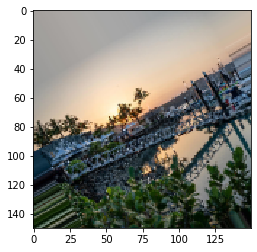

[1. 0.]


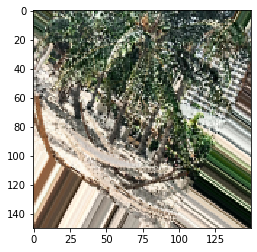

In [45]:
batch_sample = train_generator.next()
batch_sample_images, batch_sample_labels = batch_sample

for i in range(0, 2):
    image = batch_sample_images[i]
    label = batch_sample_labels[i]
    print(label)
    plt.imshow(image)
    plt.show()

In [42]:
sample_image, sample_label = sample

In [43]:
sample_label

array([[0., 1.],
       [1., 0.]], dtype=float32)

In [9]:
import efficientnet.keras as efn
conv_base = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

Using TensorFlow backend.


In [10]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))



In [11]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [12]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= train_size // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= validation_size // batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 2.8586 - acc: 0.5000 - val_loss: 6.3318 - val_acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.4167 - val_acc: 0.5000
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.0023 - acc: 1.0000 - val_loss: 3.9417 - val_acc: 0.5000
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.7282 - acc: 0.5000 - val_loss: 2.7940 - val_acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.1283 - acc: 1.0000 - val_loss: 4.2591 - val_acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 1.8591 - acc: 0.5000 - val_loss: 2.3057 - val_acc: 0.5000
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 1.5800 - acc: 0.5000 - val_loss: 4.2498 - val_acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 2s 2s/step - loss: 2.3150 - acc: 0.5000 - val

In [15]:
model_save_path = os.path.join(base_dir, 'models')
os.makedirs(model_save_path, exist_ok=True)
model.save(os.path.join(model_save_path, 'hamiltonisland-status.h5'))

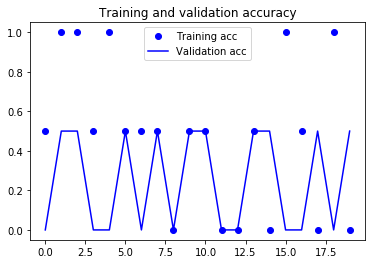

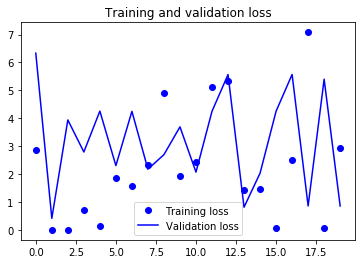

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

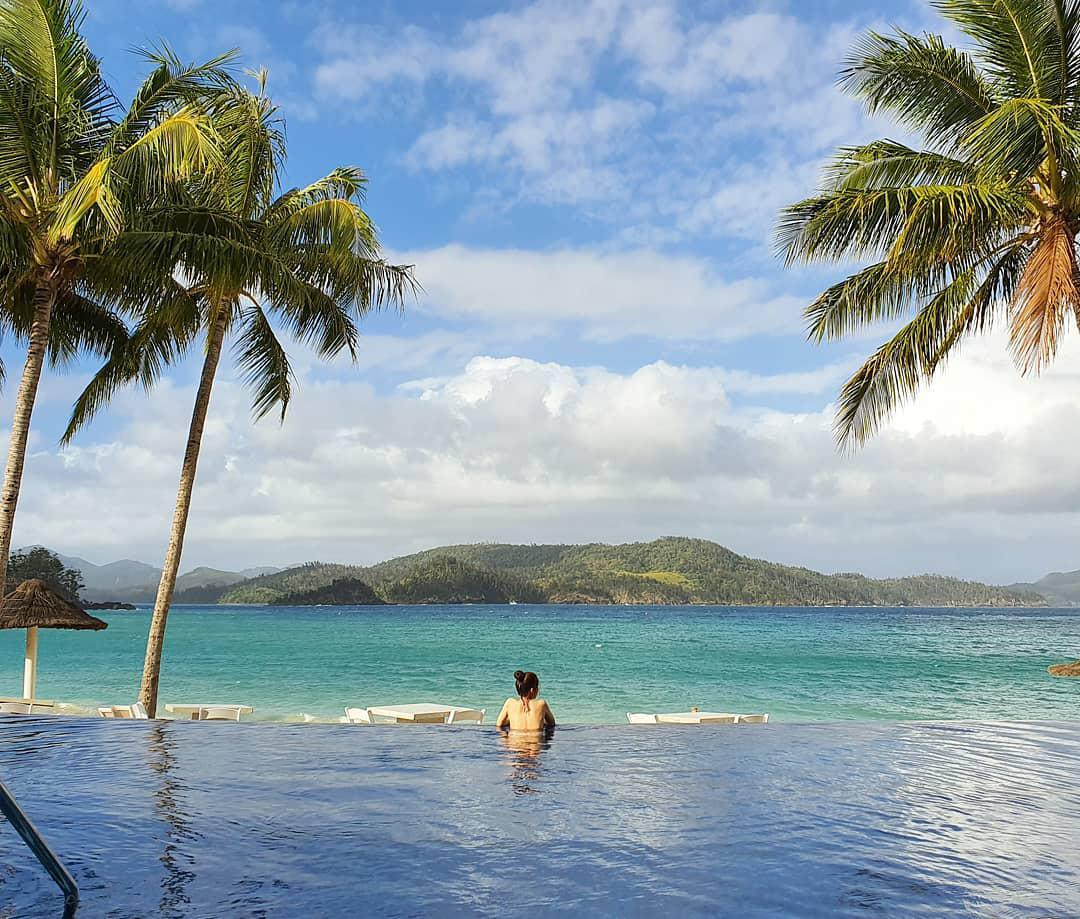

In [24]:
import IPython
published_img = os.path.join(base_dir, 'test', 'published', test_published[-1][0] + '.jpg')
IPython.display.Image(filename=published_img)


In [27]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    print(result)
    result = result[0][0]
    print(result)
    if result > 0.5:
        status = "published"
    else:
        status = "disabled"
        result = 1 - result
    return status,result

print(predict_image(published_img))


[[0.14944978 0.85055023]]
0.14944978
('disabled', 0.8505502194166183)
